# Capstone Project : Tourism Recommendation System
## Content-Based and Collaborative Filtering

Membuat tourism recommendation system menggunakan 2 pendekatan:
1. **Content-Based Filtering** - Recommends wisata berdasarkan item features
2. **Collaborative Filtering** - Recommends wisata berdasarkan user behavior patterns

---


#Data loading

In [ ]:
import os
import random
import zipfile
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import nltk
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
rating_url = 'https://drive.google.com/uc?id=1e9qaXvjAkNCCz20TolC07x8jCTj_gelR'
destinasi_url = 'https://drive.google.com/uc?id=1BXS2huXlxMVQz6CbhBibxJoAEZhScNSs'
rating_df = pd.read_csv(rating_url)
destinasi_df = pd.read_csv(destinasi_url)

In [ ]:
rating_df.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


In [ ]:
destinasi_df.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12,LINK GAMBAR
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1.0,https://res.cloudinary.com/dtm30k9uc/image/upl...
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.1376448, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2.0,https://res.cloudinary.com/dtm30k9uc/image/upl...
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.1253124, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3.0,https://res.cloudinary.com/dtm30k9uc/image/upl...
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.3024459, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4.0,https://res.cloudinary.com/dtm30k9uc/image/upl...
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5.0,https://res.cloudinary.com/dtm30k9uc/image/upl...


#Data Understanding

## Struktur dan Statistik Data Frame

In [ ]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16378 entries, 0 to 16377
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        16378 non-null  int64
 1   Place_Id       16378 non-null  int64
 2   Place_Ratings  16378 non-null  int64
dtypes: int64(3)
memory usage: 384.0 KB


In [ ]:
rating_df.describe()

,User_Id,Place_Id,Place_Ratings
count,16378.000000,16378.000000,16378.000000
mean,197.018928,291.511906,3.030895
std,120.303112,171.763507,1.394919
min,1.000000,1.000000,1.000000
25%,96.000000,145.000000,2.000000
50%,189.000000,288.000000,3.000000
75%,284.000000,433.000000,4.000000
max,450.000000,604.000000,5.000000


In [ ]:
destinasi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604 entries, 0 to 603
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      604 non-null    int64  
 1   Place_Name    604 non-null    object 
 2   Description   604 non-null    object 
 3   Category      604 non-null    object 
 4   City          604 non-null    object 
 5   Price         604 non-null    int64  
 6   Rating        604 non-null    float64
 7   Time_Minutes  372 non-null    float64
 8   Coordinate    604 non-null    object 
 9   Lat           604 non-null    float64
 10  Long          604 non-null    float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   437 non-null    float64
 13  LINK GAMBAR   604 non-null    object 
dtypes: float64(6), int64(2), object(6)
memory usage: 66.2+ KB


In [ ]:
destinasi_df.describe()

,Place_Id,Price,Rating,Time_Minutes,Lat,Long,Unnamed: 11,Unnamed: 12
count,604.000000,604.000000,604.000000,372.000000,604.000000,604.000000,0.0,437.000000
mean,302.500000,24083.112583,4.408444,93.830645,-7.284823,109.827058,NaN,219.000000
std,174.504059,58485.815884,0.220458,48.808342,0.708689,2.063525,NaN,126.295289
min,1.000000,0.000000,3.400000,10.000000,-8.446960,103.931398,NaN,1.000000
25%,151.750000,0.000000,4.200000,60.000000,-7.805344,107.610148,NaN,110.000000
50%,302.500000,7500.000000,4.400000,90.000000,-7.302349,110.410540,NaN,219.000000
75%,453.250000,22250.000000,4.600000,120.000000,-6.896927,110.814810,NaN,328.000000
max,604.000000,900000.000000,5.000000,360.000000,1.078880,113.691950,NaN,437.000000


## Missing and Duplicate Value

In [ ]:
rating_df.isna().sum()

,0
User_Id,0
Place_Id,0
Place_Ratings,0


In [ ]:
destinasi_df.isna().sum()

,0
Place_Id,0
Place_Name,0
Description,0
Category,0
City,0
Price,0
Rating,0
Time_Minutes,232
Coordinate,0
Lat,0


In [ ]:
print(f"Total duplicate values: {rating_df.duplicated().sum()}")

Total duplicate values: 79


In [ ]:
print(f"Total duplicate values: {destinasi_df.duplicated().sum()}")

Total duplicate values: 0


## Visualisasi

In [ ]:
print("Jumlah Destinasi unik:", destinasi_df['Place_Name'].nunique())
print('\n')
print("Jumlah Deskripsi unik:", destinasi_df['Description'].nunique())
print('\n')
print("Kategori unik:", destinasi_df['Category'].unique())
print("Jumlah Kategori unik:", destinasi_df['Category'].nunique())
print('\n')
print("Kota unik:", destinasi_df['City'].unique())
print("Jumlah kota unik:", destinasi_df['City'].nunique())
print('\n')
harga_unik = np.sort(destinasi_df['Price'].unique())[::-1]
print("Harga unik:", harga_unik)
print("Jumlah Harga unik:", destinasi_df['Price'].nunique())

Jumlah Destinasi unik: 604


Jumlah Deskripsi unik: 604


Kategori unik: ['Budaya' 'Taman Hiburan' 'Cagar Alam' 'Bahari' 'Pusat Perbelanjaan'
 'Tempat Ibadah']
Jumlah Kategori unik: 6


Kota unik: ['Jakarta' 'Yogyakarta' 'Bandung' 'Semarang' 'Surabaya' 'Malang' 'Batu'
 'Solo' 'Karanganyar' 'Klaten' 'Boyolali' 'Sragen' 'Sukoharjo' 'Jember']
Jumlah kota unik: 14


Harga unik: [900000 500000 375000 300000 280000 270000 250000 220000 200000 185000
 180000 175000 150000 140000 125000 120000 115000 110000 100000  95000
  94000  85000  81000  80000  75000  70000  65000  63700  60000  55000
  50000  45000  40000  37500  35000  30000  27000  25000  23000  22000
  20000  15000  12000  11000  10000   9000   8000   7500   7000   6000
   5500   5000   4000   3000   2500   2000   1000      0]
Jumlah Harga unik: 58


In [ ]:
print("Jumlah pengguna unik:", rating_df['User_Id'].nunique())
print('\n')
print("Jumlah tempat wisata unik yang dirating:", rating_df['Place_Id'].nunique())

Jumlah pengguna unik: 450


Jumlah tempat wisata unik yang dirating: 604


In [ ]:
budget_counts = destinasi_df['Price'].value_counts()
budget_counts

,count
Price,
0,173
10000,76
5000,71
15000,38
25000,23
50000,22
20000,21
3000,20
35000,14


In [ ]:
rating_counts = rating_df['Place_Ratings'].value_counts()
rating_counts

,count
Place_Ratings,
2,3378
4,3368
3,3348
5,3271
1,3013


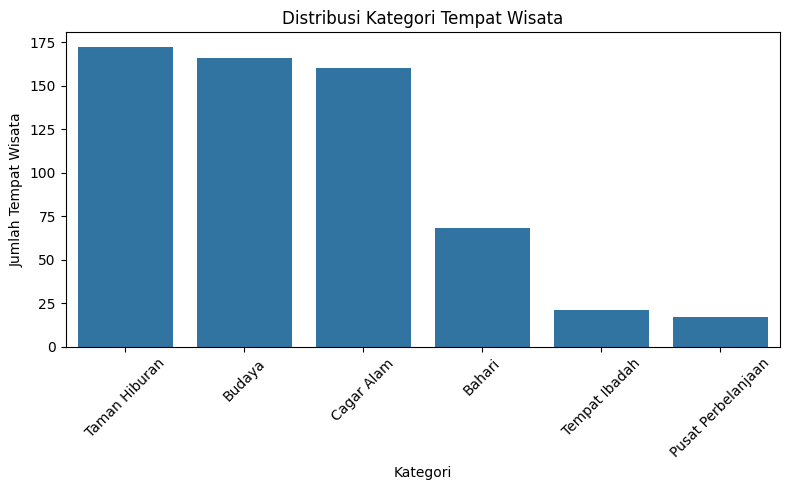

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(data=destinasi_df, x='Category', order=destinasi_df['Category'].value_counts().index)
plt.title('Distribusi Kategori Tempat Wisata')
plt.xticks(rotation=45)
plt.xlabel('Kategori')
plt.ylabel('Jumlah Tempat Wisata')
plt.tight_layout()
plt.show()

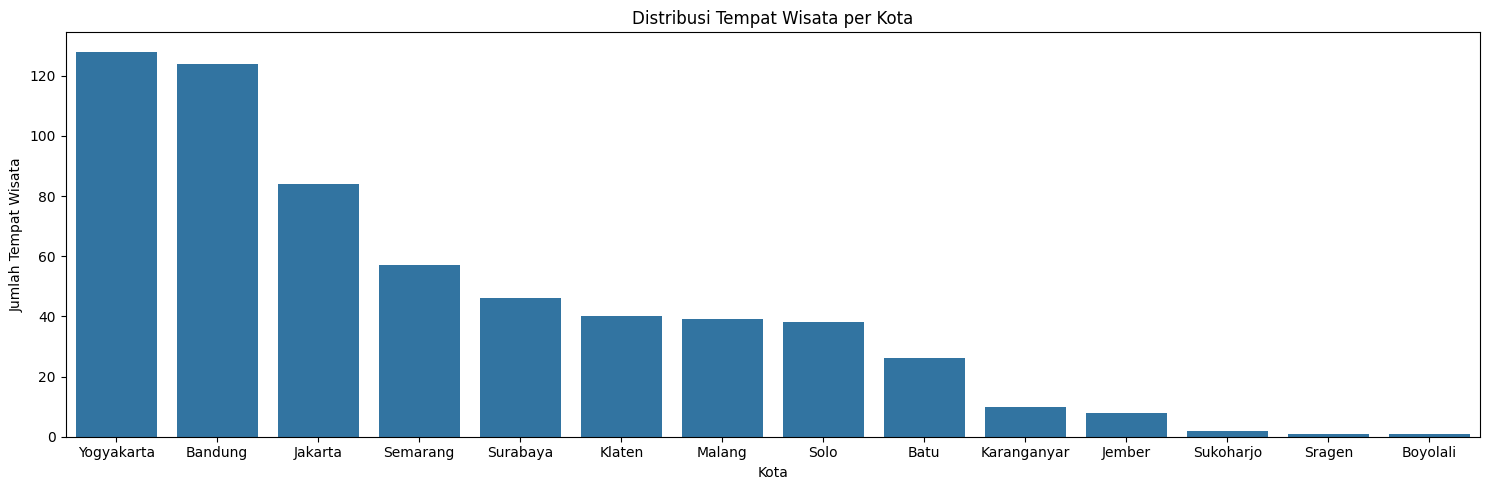

In [ ]:
plt.figure(figsize=(15, 5))
sns.countplot(data=destinasi_df, x='City', order=destinasi_df['City'].value_counts().index)
plt.title('Distribusi Tempat Wisata per Kota')
plt.xlabel('Kota')
plt.ylabel('Jumlah Tempat Wisata')
plt.tight_layout()
plt.show()

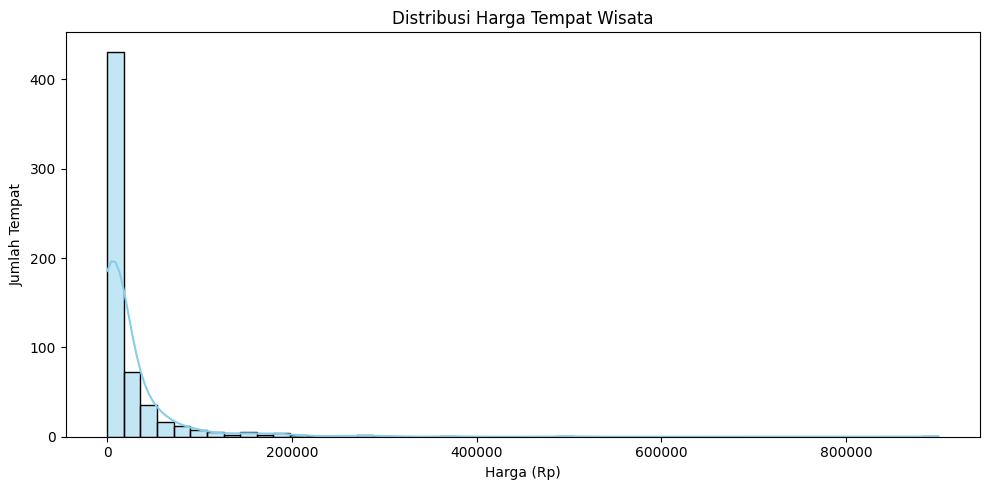

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(destinasi_df['Price'], bins=50, kde=True, color='skyblue')
plt.title('Distribusi Harga Tempat Wisata')
plt.xlabel('Harga (Rp)')
plt.ylabel('Jumlah Tempat')
plt.tight_layout()
plt.show()

<ipython-input-20-2329212449>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Rating', data=destinasi_df, palette='viridis')


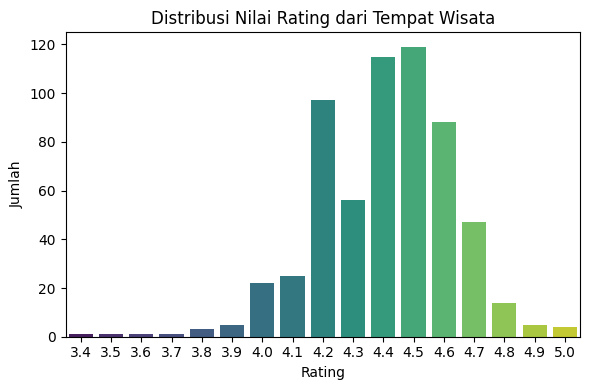

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Rating', data=destinasi_df, palette='viridis')
plt.title('Distribusi Nilai Rating dari Tempat Wisata')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

<ipython-input-21-1834054429>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Place_Ratings', data=rating_df, palette='viridis')


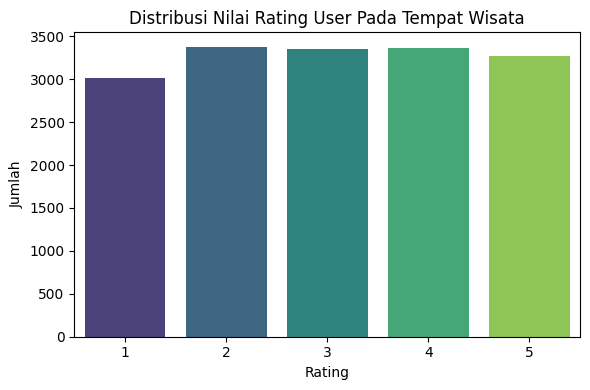

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Place_Ratings', data=rating_df, palette='viridis')
plt.title('Distribusi Nilai Rating User Pada Tempat Wisata')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

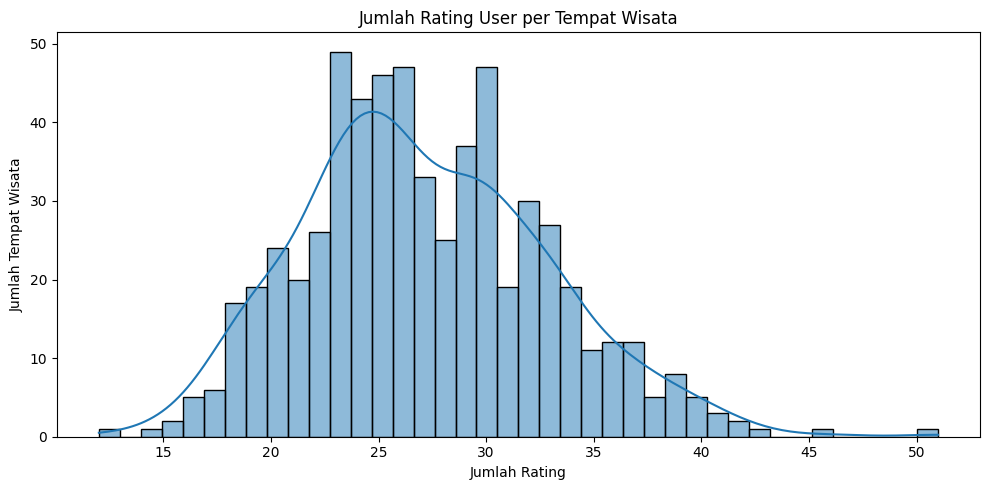

In [ ]:
place_rating_counts = rating_df['Place_Id'].value_counts()

plt.figure(figsize=(10, 5))
sns.histplot(place_rating_counts, bins=40, kde=True)
plt.title('Jumlah Rating User per Tempat Wisata')
plt.xlabel('Jumlah Rating')
plt.ylabel('Jumlah Tempat Wisata')
plt.tight_layout()
plt.show()

## Insights:

- Data duplikat pada `rating_df` perlu dihapus untuk keakuratan model.
- Missing value terutama pada kolom `Time_Minutes`, `Unnamed: 11`, dan `Unnamed: 12` perlu diatasi atau dibuang jika tidak relevan.
- Kekayaan data deskriptif (deskripsi wisata + kategori + kota) bisa digunakan untuk model berbasis konten (content-based).
- Rating dari pengguna dan destinasi cocok untuk sistem berbasis kolaboratif (collaborative filtering).
- Kategori dapat membantu dalam pembuatan sistem filter/sort sesuai preferensi pengguna.


# Main Data Preparation

## Handling Missing and Duplicate Values

In [ ]:
destinasi_df = destinasi_df.drop_duplicates()
rating_df = rating_df.drop_duplicates()
print(f"Jumlah duplikat di df_place: {destinasi_df.duplicated().sum()}")
print(f"Jumlah duplikat di df_rating: {rating_df.duplicated().sum()}")

Jumlah duplikat di df_place: 0
Jumlah duplikat di df_rating: 0


In [ ]:
destinasi_df.info()
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604 entries, 0 to 603
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      604 non-null    int64  
 1   Place_Name    604 non-null    object 
 2   Description   604 non-null    object 
 3   Category      604 non-null    object 
 4   City          604 non-null    object 
 5   Price         604 non-null    int64  
 6   Rating        604 non-null    float64
 7   Time_Minutes  372 non-null    float64
 8   Coordinate    604 non-null    object 
 9   Lat           604 non-null    float64
 10  Long          604 non-null    float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   437 non-null    float64
 13  LINK GAMBAR   604 non-null    object 
dtypes: float64(6), int64(2), object(6)
memory usage: 66.2+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 16299 entries, 0 to 16377
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype

## Hapus Kolom yang Tidak Relevan

In [ ]:
destinasi_df = destinasi_df.drop(columns=['Unnamed: 11', 'Unnamed: 12','Time_Minutes'])

In [ ]:
destinasi_df.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Coordinate,Lat,Long,LINK GAMBAR
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,https://res.cloudinary.com/dtm30k9uc/image/upl...
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,"{'lat': -6.1376448, 'lng': 106.8171245}",-6.137645,106.817125,https://res.cloudinary.com/dtm30k9uc/image/upl...
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,"{'lat': -6.1253124, 'lng': 106.8335377}",-6.125312,106.833538,https://res.cloudinary.com/dtm30k9uc/image/upl...
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,"{'lat': -6.3024459, 'lng': 106.8951559}",-6.302446,106.895156,https://res.cloudinary.com/dtm30k9uc/image/upl...
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,https://res.cloudinary.com/dtm30k9uc/image/upl...


## Insights:

1. **Penanganan Missing Values**  
   - Kolom `Time_Minutes` tidak begitu diperlukan dalam project ini jadi kami memutuskan untuk menghapusnya karena value didalamnya juga tiadk lengkap disemua destinasi.
   - Kolom `Unnamed: 11` dan `Unnamed: 12` menunjukkan banyak nilai kosong (`NaN`), dengan `Unnamed: 11` tidak memiliki data sama sekali. Hal ini menunjukkan bahwa kolom tersebut tidak relevan dan dapat dihapus.

2. **Penanganan Duplikat**  
   - Data duplikat pada `destinasi_df` dan `rating_df` telah dihapus.  
     - Jumlah duplikat pada `destinasi_df`: 0  
     - Jumlah duplikat pada `rating_df`: 0  
   - Setelah proses ini, data menjadi lebih bersih dan siap digunakan dalam pelatihan model machine learning tanpa adanya pengaruh negatif dari data ganda.

3. **Penghapusan Kolom Tidak Relevan**  
   - Kolom `Unnamed: 11`, `Unnamed: 12`, dan `Time_Minutes` dihapus dari `destinasi_df`


# **Content Based Filtering**

## Data Preparation for Content-Based Filtering (CBF)

In [ ]:
destinasi_df.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Coordinate,Lat,Long,LINK GAMBAR
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,https://res.cloudinary.com/dtm30k9uc/image/upl...
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,"{'lat': -6.1376448, 'lng': 106.8171245}",-6.137645,106.817125,https://res.cloudinary.com/dtm30k9uc/image/upl...
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,"{'lat': -6.1253124, 'lng': 106.8335377}",-6.125312,106.833538,https://res.cloudinary.com/dtm30k9uc/image/upl...
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,"{'lat': -6.3024459, 'lng': 106.8951559}",-6.302446,106.895156,https://res.cloudinary.com/dtm30k9uc/image/upl...
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,https://res.cloudinary.com/dtm30k9uc/image/upl...


In [ ]:
cb_df = destinasi_df[['Place_Id','Place_Name', 'Category', 'City']].copy()

In [ ]:
cb_df['Combined_Features'] = cb_df['Place_Name'] + ' ' + cb_df['Category'] + ' ' + cb_df['City']

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
import re
def preprocess_text(text):
    """
    Preprocess text data by:
    1. Converting to lowercase
    2. Removing non-alphabetic characters

    """
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    stop_words = set(stopwords.words('indonesian'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

cb_df['Combined_Features'] = cb_df['Combined_Features'].apply(preprocess_text)


In [ ]:
cb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604 entries, 0 to 603
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Place_Id           604 non-null    int64 
 1   Place_Name         604 non-null    object
 2   Category           604 non-null    object
 3   City               604 non-null    object
 4   Combined_Features  604 non-null    object
dtypes: int64(1), object(4)
memory usage: 23.7+ KB


In [ ]:
vectorizer = TfidfVectorizer()
vectorizer.fit(cb_df['Combined_Features'])
feature_names = vectorizer.get_feature_names_out()
feature_names

array(['abang', 'abdullah', 'ade', 'adhyatma', 'adventure', 'africa',
       'afrika', 'ageng', 'agro', 'agrowisata', 'agung', 'ahmad', 'air',
       'aji', 'al', 'alakbar', 'alam', 'alas', 'alimtizaj', 'alive',
       'alun', 'alunalun', 'amazing', 'ambarawa', 'ancol', 'and',
       'anggrek', 'angke', 'angklung', 'angkut', 'anjlok', 'anom',
       'anteng', 'api', 'aquarium', 'ardilla', 'arema', 'argo', 'art',
       'artha', 'aseupan', 'asia', 'asri', 'atlantis', 'ayodya',
       'babakan', 'badak', 'baduga', 'badut', 'bahari', 'bajulmati',
       'balai', 'balekambang', 'baluwarti', 'bambu', 'banaran', 'bandros',
       'bandung', 'bangsal', 'bangunrejo', 'banjarsari', 'bank', 'bantal',
       'banteng', 'banyu', 'barat', 'barli', 'barn', 'baron', 'baruna',
       'barunawati', 'basoeki', 'batik', 'batu', 'batununggal', 'bay',
       'bayat', 'bbws', 'bby', 'becici', 'begonia', 'belanda', 'bendung',
       'bendungan', 'bengawan', 'bengkung', 'bening', 'bentara',
       'benteng', 

In [ ]:
tfidf_matrix = vectorizer.fit_transform(cb_df['Combined_Features'])
tfidf_matrix.shape

(604, 920)

In [ ]:
dense_tfidf = tfidf_matrix.todense()
dense_tfidf

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

## Modeling

In [ ]:
cosine_sim = cosine_similarity(tfidf_matrix)
print(cosine_sim)
cosine_sim.shape

[[1.         0.19658422 0.10647113 ... 0.         0.         0.        ]
 [0.19658422 1.         0.09352343 ... 0.         0.         0.        ]
 [0.10647113 0.09352343 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.07780173 0.07295119]
 [0.         0.         0.         ... 0.07780173 1.         0.06643772]
 [0.         0.         0.         ... 0.07295119 0.06643772 1.        ]]


(604, 604)

In [ ]:
cosine_sim_df = pd.DataFrame(
    cosine_sim, index=cb_df.Place_Name, columns=cb_df.Place_Name)
cosine_sim_df.sample(10, axis=0)

Place_Name,Monumen Nasional,Kota Tua,Dunia Fantasi,Taman Mini Indonesia Indah (TMII),Atlantis Water Adventure,Taman Impian Jaya Ancol,Kebun Binatang Ragunan,Ocean Ecopark,Pelabuhan Marina,Pulau Tidung,...,Umbul Brintik,Embung Tirto Mulyo,Taman Kamboja,New Taman Wisata Jlengut,Janti Park,Wisata Sungai Kalimasada,Wisata Puncak Clongop,Wahana Soko Alas,River Tubing Pusur Adventure,Green Valley Coffee Camp
Place_Name,,,,,,,,,,,,,,,,,,,,,
Happyfarm Ciwidey,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.092360,0.000000,0.000000,0.000000,...,0.000000,0.084899,0.000000,0.000000,0.000000,0.095945,0.099982,0.082041,0.000000,0.0
Kemuning Sky Hills,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.075603,0.000000,0.000000,0.000000,...,0.000000,0.069495,0.000000,0.000000,0.000000,0.078537,0.081842,0.067157,0.000000,0.0
Pulau Semak Daun,0.094707,0.083190,0.071912,0.057879,0.066214,0.059491,0.066785,0.071912,0.157220,0.418905,...,0.088657,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.061341,0.0
Pantai Banyu Anjlok,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.085183,0.000000,0.000000,0.000000,...,0.000000,0.078301,0.000000,0.000000,0.000000,0.088489,0.092213,0.075666,0.000000,0.0
Monumen Batik Yogyakarta,0.371648,0.063981,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.137727,0.000000,0.000000,0.0
Alun Alun Selatan Yogyakarta,0.000000,0.000000,0.064646,0.076814,0.059524,0.078954,0.000000,0.064646,0.000000,0.000000,...,0.000000,0.000000,0.109680,0.085395,0.071500,0.000000,0.086966,0.000000,0.000000,0.0
Curug Luhur Waterfall,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083440,0.000000,0.000000,0.000000,...,0.000000,0.076699,0.000000,0.000000,0.000000,0.086679,0.090326,0.074118,0.000000,0.0
Pulau Tidung,0.115561,0.101508,0.087746,0.070623,0.080794,0.072590,0.081490,0.087746,0.191838,1.000000,...,0.108179,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.074847,0.0
Pracimasana Mangkunegaran,0.064822,0.056939,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [ ]:
def recommend_places(place_name, top_n):
    if place_name not in cosine_sim_df.index:
        raise ValueError(f"Tempat '{place_name}' tidak ditemukan di data.")

    sim_scores = cosine_sim_df[place_name]
    sim_scores = sim_scores[sim_scores.index != place_name]

    top_indices = sim_scores.sort_values(ascending=False).head(top_n).index

    referensi_tempat = cb_df[cb_df['Place_Name'] == place_name].copy()
    referensi_tempat['Similarity_Score'] = 1.0

    rekomendasi = cb_df[cb_df['Place_Name'].isin(top_indices)].copy()
    rekomendasi['Similarity_Score'] = sim_scores[top_indices].values
    hasil = pd.concat([referensi_tempat, rekomendasi], ignore_index=True)

    return hasil[['Place_Name', 'Category', 'City', 'Similarity_Score']]


In [ ]:
recommend_places('Monumen Nasional', top_n=5)

,Place_Name,Category,City,Similarity_Score
0,Monumen Nasional,Budaya,Jakarta,1.000000
1,Museum Nasional,Budaya,Jakarta,0.713712
2,Galeri Nasional Indonesia,Budaya,Jakarta,0.640271
3,Museum Kebangkitan Nasional,Budaya,Jakarta,0.577997
4,Perpustakaan Nasional,Budaya,Jakarta,0.524866
5,Monumen Pers Nasional,Budaya,Solo,0.507086


## **Insights:**

* **Penggabungan Fitur Teks**
  Kolom `Nama Tempat`, `Kategori`, dan `Kota` digabung menjadi satu kolom `Combined_Features` untuk merepresentasikan karakteristik tiap destinasi.

* **Pembersihan & Normalisasi Teks**
  Teks diubah ke huruf kecil (lowercase) dan dibersihkan dari karakter non-alfabet untuk menjaga konsistensi.

* **Ekstraksi Fitur dengan TF-IDF**
  `Combined_Features` diubah menjadi representasi numerik menggunakan **TF-IDF Vectorizer**, yang menangkap pentingnya kata dalam konteks global.

* **Perhitungan Kemiripan dengan Cosine Similarity**
  Hasil TF-IDF digunakan untuk menghitung **cosine similarity** antar destinasi, guna mengukur seberapa mirip satu tempat dengan tempat lainnya berdasarkan deskripsi kontennya.


# **Collaborative Filtering**

## Data Preparation for Collaborative Filtering (CF)

In [ ]:
cf_df = rating_df.copy()

In [ ]:
cf_df.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


In [ ]:
user_to_user_encoded = {u: i for i, u in enumerate(cf_df['User_Id'].unique())}
user_encoded_to_user = dict(enumerate(cf_df['User_Id'].unique()))

place_to_place_encoded = {p: i for i, p in enumerate(cf_df['Place_Id'].unique())}
place_encoded_to_place = dict(enumerate(cf_df['Place_Id'].unique()))

cf_df['User_Id'] = cf_df['User_Id'].map(user_to_user_encoded)
cf_df['Place_Id'] = cf_df['Place_Id'].map(place_to_place_encoded)

In [ ]:
cf_df.head()

,User_Id,Place_Id,Place_Ratings
0,0,0,3
1,0,1,2
2,0,2,5
3,0,3,3
4,0,4,4


In [ ]:
min_rating = cf_df['Place_Ratings'].min()
max_rating = cf_df['Place_Ratings'].max()
cf_df['Place_Ratings'] = (cf_df['Place_Ratings'] - min_rating) / (max_rating - min_rating)

In [ ]:
cf_df.head()

,User_Id,Place_Id,Place_Ratings
0,0,0,0.50
1,0,1,0.25
2,0,2,1.00
3,0,3,0.50
4,0,4,0.75


In [ ]:
cf_df = cf_df.sample(frac=1, random_state=42)
cf_df.head()

,User_Id,Place_Id,Place_Ratings
10381,37,456,0.50
5341,161,255,0.50
6960,208,318,0.25
1510,46,243,0.25
3140,96,338,1.00


In [ ]:
train_data, val_data = train_test_split(
    cf_df,
    test_size=0.2,
    random_state=42,
)
print(f"Ukuran data latih: {len(train_data)}")
print(f"Ukuran data validasi: {len(val_data)}")

Ukuran data latih: 13039
Ukuran data validasi: 3260


## Modeling

In [ ]:
x_train = np.array(list(zip(train_data['User_Id'], train_data['Place_Id'])))
y_train = train_data['Place_Ratings']
x_val = np.array(list(zip(val_data['User_Id'], val_data['Place_Id'])))
y_val = val_data['Place_Ratings']

In [ ]:
print(f"Bentuk data input latih: {x_train.shape}")
print(f"Bentuk data output latih: {y_train.shape}")
print(f"Bentuk data input validasi: {x_val.shape}")
print(f"Bentuk data output validasi: {y_val.shape}")

Bentuk data input latih: (13039, 2)
Bentuk data output latih: (13039,)
Bentuk data input validasi: (3260, 2)
Bentuk data output validasi: (3260,)


In [ ]:
@tf.keras.utils.register_keras_serializable()
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_places, embedding_size, dropout_rate, **kwargs):
        super().__init__(**kwargs)

        self.num_users = num_users
        self.num_places = num_places
        self.embedding_size = embedding_size
        self.dropout_rate = dropout_rate

        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)

        self.place_embedding = layers.Embedding(
            num_places,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
        )
        self.place_bias = layers.Embedding(num_places, 1)

        self.dropout = layers.Dropout(dropout_rate)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_vector = self.dropout(user_vector)

        user_bias = self.user_bias(inputs[:, 0])
        place_vector = self.place_embedding(inputs[:, 1])
        place_vector = self.dropout(place_vector)

        place_bias = self.place_bias(inputs[:, 1])

        dot_user_place = tf.reduce_sum(user_vector * place_vector, axis=1, keepdims=True)
        x = dot_user_place + user_bias + place_bias
        return tf.squeeze(x, axis=1)

    def get_config(self):
        config = super().get_config()
        config.update({
            'num_users': self.num_users,
            'num_places': self.num_places,
            'embedding_size': self.embedding_size,
            'dropout_rate': self.dropout_rate,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [ ]:
num_users = len(user_to_user_encoded)
num_places = len(place_to_place_encoded)
dropout_rate = 0.4
embedding_size = 12

In [ ]:
model = RecommenderNet(num_users, num_places, embedding_size, dropout_rate)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)

In [ ]:
model(np.array([[0, 0]]))
model.summary()

Model: "recommender_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (1, 12)                │         5,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (1, 1)                 │           450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (1, 12)                │         7,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (1, 1)                 │           604 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,702 (53.52 KB)

 Trainable params: 13,702 (53.52 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_root_mean_squared_error',
        patience=5,
        restore_best_weights=True
    )
]

In [ ]:
history = model.fit(
    x_train,
    y_train,
    batch_size=8,
    epochs=100,
    validation_data=(x_val, y_val),
    callbacks=callbacks
)

Epoch 1/100
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 4.8881 - root_mean_squared_error: 0.6175 - val_loss: 4.1360 - val_root_mean_squared_error: 0.6015
Epoch 2/100
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 3.9918 - root_mean_squared_error: 0.6000 - val_loss: 3.4668 - val_root_mean_squared_error: 0.5910
Epoch 3/100
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3.3660 - root_mean_squared_error: 0.5944 - val_loss: 2.9320 - val_root_mean_squared_error: 0.5811
Epoch 4/100
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 2.8808 - root_mean_squared_error: 0.5826 - val_loss: 2.5270 - val_root_mean_squared_error: 0.5710
Epoch 5/100
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 2.4625 - root_mean_squared_error: 0.5693 - val_loss: 2.1482 - val_root_mean_squared_error: 0.5603
Epoch 6/100
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 2.0299 - root_mean_squared_error: 0.5568 - val_loss: 1.8459 - val_root_mean_squared_error: 0.5489
Epoch 7/100
1630/1630 ━━━━━━━━━━━━

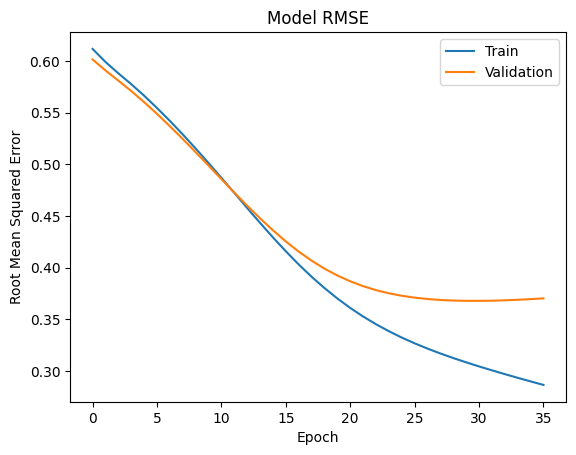

In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model RMSE')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
def recommend_places_for_user(user_id, top_n=10):
    if user_id not in user_to_user_encoded:
        print(f"User ID {user_id} tidak ditemukan dalam data pelatihan.")
        return None, None

    encoded_user_id = user_to_user_encoded[user_id]

    user_ratings = cf_df[cf_df['User_Id'] == encoded_user_id].copy()
    user_ratings['Place_Id'] = user_ratings['Place_Id'].map(place_encoded_to_place)

    rated_merged = pd.merge(user_ratings, destinasi_df, on='Place_Id', how='inner')

    min_rating = rating_df['Place_Ratings'].min()
    max_rating = rating_df['Place_Ratings'].max()
    rated_merged['Place_Ratings'] = rated_merged['Place_Ratings'] * (max_rating - min_rating) + min_rating

    rated_places_df = rated_merged[['Place_Name', 'Category', 'City', 'Place_Ratings']]

    all_place_ids = np.array(list(place_to_place_encoded.values()))
    rated_place_ids = user_ratings['Place_Id'].values
    unrated_place_ids = np.setdiff1d(all_place_ids, rated_place_ids)

    user_place_array = np.array([[encoded_user_id, pid] for pid in unrated_place_ids])
    predicted_ratings = model.predict(user_place_array).flatten()

    top_indices = predicted_ratings.argsort()[::-1][:top_n]
    top_place_ids = unrated_place_ids[top_indices]
    top_ratings = predicted_ratings[top_indices]

    recommended_df = pd.DataFrame({
        'Encoded_Place_Id': top_place_ids,
        'Predicted_Rating': top_ratings
    })

    recommended_df['Place_Id'] = recommended_df['Encoded_Place_Id'].map(place_encoded_to_place)
    recommended_places_df = recommended_df.merge(destinasi_df, on='Place_Id')
    recommended_places_df = recommended_places_df[['Place_Name', 'Category', 'City', 'Predicted_Rating']]
    top_rated_places_df = rated_places_df.sort_values(by='Place_Ratings', ascending=False).head(top_n)
    print(f"\nTempat yang sudah dirating oleh User ID {user_id}:\n")
    display(top_rated_places_df)

    print(f"\nTop {top_n} rekomendasi tempat untuk User ID {user_id}:\n")
    display(recommended_places_df)

    return rated_places_df, recommended_places_df

In [ ]:
top_rated_places_df, recommended_df = recommend_places_for_user(user_id=12, top_n=10)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Tempat yang sudah dirating oleh User ID 12:



,Place_Name,Category,City,Place_Ratings
0,Waterboom PIK (Pantai Indah Kapuk),Taman Hiburan,Jakarta,5.0
12,Cibubur Garden Diary (Cibugary),Cagar Alam,Jakarta,5.0
9,Taman Hutan Raya Ir. H. Juanda,Cagar Alam,Bandung,5.0
36,Atlantis Water Adventure,Taman Hiburan,Jakarta,5.0
44,Monumen Batik Yogyakarta,Budaya,Yogyakarta,5.0
41,Galeri Indonesia Kaya,Budaya,Jakarta,5.0
42,Taman Menteng,Taman Hiburan,Jakarta,5.0
24,Galaxy Waterpark Jogja,Taman Hiburan,Yogyakarta,5.0
25,Sumur Gumuling,Taman Hiburan,Yogyakarta,5.0
29,Taman Badak,Taman Hiburan,Bandung,5.0



Top 10 rekomendasi tempat untuk User ID 12:



,Place_Name,Category,City,Predicted_Rating
0,Keraton Surabaya,Budaya,Surabaya,0.795989
1,Desa Wisata Gamplong,Taman Hiburan,Yogyakarta,0.734960
2,Selasar Sunaryo Art Space,Taman Hiburan,Bandung,0.702987
3,Museum Nike Ardilla,Budaya,Bandung,0.698942
4,Taman Pelangi,Taman Hiburan,Surabaya,0.682453
5,Situ Patenggang,Cagar Alam,Bandung,0.676492
6,Monumen Palagan Ambarawa,Budaya,Semarang,0.676291
7,Puncak Gunung Api Purba - Nglanggeran,Cagar Alam,Yogyakarta,0.670356
8,Monumen Selamat Datang,Budaya,Jakarta,0.666541
9,Trans Studio Bandung,Taman Hiburan,Bandung,0.663771


## Insights:

* **Persiapan Data**:
  * Menggunakan `LabelEncoder` untuk mengubah `User_Id` dan `Place_Id` ke format numerik.
  * Normalisasi nilai rating.
  * Data dibagi menjadi data latih dan data validasi.

* **Model**:
  * Menggunakan embedding layer untuk representasi user dan place.
  * Menggabungkan embedding, lalu diproses dengan dropout dan dense layer.
  * Output: satu nilai prediksi rating.

* **Pelatihan**:
  * Optimizer: Adam.
  * Loss: Binary Crossentropy.
  * Evaluasi: Root Mean Squared Error (RMSE).

* **Hasil Akhir (Epoch 36)**:
  * **Loss training**: 0.6089 (RMSE: 0.2890)
  * **Loss validasi**: 0.7275 (RMSE: 0.3703)
  * Model menunjukkan performa prediksi yang cukup baik dengan error relatif rendah.


# Save

## Save model Content-Based Filtering

In [ ]:
os.makedirs("models", exist_ok=True)
os.makedirs("data", exist_ok=True)

In [ ]:
joblib.dump(cosine_sim_df, 'models/cosine_sim_df.pkl')
joblib.dump(vectorizer, 'models/tfidf_vectorizer.pkl')
cb_df.to_csv('data/cb_df.csv', index=False)

## Save model Collaborative Filtering

In [ ]:
model.save('models/collab_model.keras')

joblib.dump(user_to_user_encoded, 'models/user_to_user_encoded.pkl')
joblib.dump(place_to_place_encoded, 'models/place_to_place_encoded.pkl')

rating_df.to_csv('data/rating_df.csv', index=False)
destinasi_df.to_csv('data/destinasi_df.csv', index=False)

Insight:

* Membuat folder `models/` dan `data/` untuk menyimpan model dan data.
* Menyimpan model **Content-Based Filtering**:

  * Matriks kemiripan (`cosine_sim_df`) dan TF-IDF vectorizer.
  * Dataset konten (`cb_df`) untuk rekomendasi berbasis deskripsi.
* Menyimpan model **Collaborative Filtering**:

  * Model neural network hasil pelatihan (`collab_model.keras`).
  * Encoder user dan destinasi (`user_to_user_encoded`, `place_to_place_encoded`).
  * Dataset interaksi (`rating_df`) dan informasi destinasi (`destinasi_df`).
* Memungkinkan penggunaan ulang model dan data tanpa retraining.
* Siap untuk deployment atau pengujian lebih lanjut.


# Preparation for Integration & New Inference

## Load Data yang Sudah Disimpan

In [ ]:
destinasi_df = pd.read_csv('data/destinasi_df.csv')
rating_df = pd.read_csv('data/rating_df.csv')

## Load Model

In [ ]:
cosine_sim_df = joblib.load('models/cosine_sim_df.pkl')
cb_df = pd.read_csv('data/cb_df.csv')
tfidf_vectorizer = joblib.load('models/tfidf_vectorizer.pkl')

In [ ]:
cf_model = tf.keras.models.load_model(
    'models/collab_model.keras',
    custom_objects={'RecommenderNet': RecommenderNet}
)

user_to_user_encoded = joblib.load('models/user_to_user_encoded.pkl')
place_to_place_encoded = joblib.load('models/place_to_place_encoded.pkl')


## Definisi Fungsi Model untuk Tahap Deploy

In [ ]:
def content_based_recommendations(place_name, similarity_data=cosine_sim_df, items=cb_df, k=5):

    if place_name not in items['Place_Name'].values:
        return pd.DataFrame()

    index = items[items['Place_Name'] == place_name].index[0]
    sim_scores = list(enumerate(similarity_data.iloc[index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:k+1]

    place_indices = [i[0] for i in sim_scores]
    place_ids = items.iloc[place_indices]['Place_Id'].tolist()

    return place_ids

In [ ]:
def collaborative_filtering_recommendations(user_id, n=5):

    if user_id not in user_to_user_encoded:
        return pd.DataFrame()

    user_encoded = user_to_user_encoded[user_id]
    place_ids = rating_df['Place_Id'].unique()
    visited_places = rating_df[rating_df['User_Id'] == user_id]['Place_Id']
    place_ids_unvisited = [p for p in place_ids if p not in visited_places]

    place_encoded_unvisited = [
        place_to_place_encoded[p] for p in place_ids_unvisited
        if p in place_to_place_encoded
    ]

    user_place_array = np.array([[user_encoded, p_enc] for p_enc in place_encoded_unvisited])
    ratings = cf_model.predict(user_place_array).flatten()
    top_ratings_indices = ratings.argsort()[-n:][::-1]
    recommended_place_ids = [place_ids_unvisited[i] for i in top_ratings_indices]

    return recommended_place_ids

In [ ]:
def get_travel_recommendations(user_id, favorite_place=None):
    all_recommendations = []
    cf_recs = collaborative_filtering_recommendations(user_id)
    all_recommendations.extend(cf_recs)

    if favorite_place:
        cb_recs = content_based_recommendations(favorite_place)
        all_recommendations.extend(cb_recs)

    unique_recommendations = list(set(all_recommendations))

    recommendations_df = destinasi_df[
        destinasi_df['Place_Id'].isin(unique_recommendations)
    ]

    recommendations_df['Recommendation_Source'] = 'Hybrid'
    recommendations_df.loc[
        recommendations_df['Place_Id'].isin(cf_recs), 'Recommendation_Source'
    ] = 'Collaborative'

    if favorite_place:
        recommendations_df.loc[
            recommendations_df['Place_Id'].isin(cb_recs), 'Recommendation_Source'
        ] = 'Content-Based'

    return recommendations_df

In [ ]:
destinasi_df["Place_Id"]
destinasi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604 entries, 0 to 603
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Place_Id     604 non-null    int64  
 1   Place_Name   604 non-null    object 
 2   Description  604 non-null    object 
 3   Category     604 non-null    object 
 4   City         604 non-null    object 
 5   Price        604 non-null    int64  
 6   Rating       604 non-null    float64
 7   Coordinate   604 non-null    object 
 8   Lat          604 non-null    float64
 9   Long         604 non-null    float64
 10  LINK GAMBAR  604 non-null    object 
dtypes: float64(3), int64(2), object(6)
memory usage: 52.0+ KB


In [ ]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16299 entries, 0 to 16298
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        16299 non-null  int64
 1   Place_Id       16299 non-null  int64
 2   Place_Ratings  16299 non-null  int64
dtypes: int64(3)
memory usage: 382.1 KB


In [ ]:
cb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604 entries, 0 to 603
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Place_Id           604 non-null    int64 
 1   Place_Name         604 non-null    object
 2   Category           604 non-null    object
 3   City               604 non-null    object
 4   Combined_Features  604 non-null    object
dtypes: int64(1), object(4)
memory usage: 23.7+ KB


## Hybrid

In [ ]:
new_user_recs = get_travel_recommendations(user_id=27)
user_recs = get_travel_recommendations(
    user_id= 12,
    favorite_place= "Monumen Nasional"
)

print("Rekomendasi untuk user dengan favorite place 'Monumen Nasional':")
from IPython.display import display
display(user_recs)

print("Rekomendasi untuk user baru (tanpa favorite place):")
display(new_user_recs)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


<ipython-input-67-3026951380>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df['Recommendation_Source'] = 'Hybrid'
<ipython-input-67-3026951380>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df['Recommendation_Source'] = 'Hybrid'


Rekomendasi untuk user dengan favorite place 'Monumen Nasional':


,Place_Id,Place_Name,Description,Category,City,Price,Rating,Coordinate,Lat,Long,LINK GAMBAR,Recommendation_Source
23,24,Museum Nasional,Museum Nasional Republik Indonesia atau Museum...,Budaya,Jakarta,5000,4.6,"{'lat': -6.1764021, 'lng': 106.8215901}",-6.176402,106.821590,https://res.cloudinary.com/dtm30k9uc/image/upl...,Content-Based
39,40,Galeri Nasional Indonesia,Galeri Nasional Indonesia (bahasa Inggris: Nat...,Budaya,Jakarta,0,4.6,"{'lat': -6.1785482, 'lng': 106.8327716}",-6.178548,106.832772,https://res.cloudinary.com/dtm30k9uc/image/upl...,Content-Based
62,63,Museum Kebangkitan Nasional,Museum Kebangkitan Nasional (bahasa Inggris: M...,Budaya,Jakarta,2000,4.7,"{'lat': -6.178352, 'lng': 106.838094}",-6.178352,106.838094,https://res.cloudinary.com/dtm30k9uc/image/upl...,Content-Based
69,70,Perpustakaan Nasional,Perpustakaan Nasional adalah perpustakaan yang...,Budaya,Jakarta,0,4.7,"{'lat': -6.1812918, 'lng': 106.8268717}",-6.181292,106.826872,https://res.cloudinary.com/dtm30k9uc/image/upl...,Content-Based
133,134,Desa Wisata Gamplong,Desa Wisata Gamplong adalah desa wisata keraji...,Taman Hiburan,Yogyakarta,10000,4.4,"{'lat': -7.8055232, 'lng': 110.2374676}",-7.805523,110.237468,https://res.cloudinary.com/dtm30k9uc/image/upl...,Collaborative
252,253,Selasar Sunaryo Art Space,Selasar Sunaryo Art Space (SSAS) adalah sebuah...,Taman Hiburan,Bandung,25000,4.6,"{'lat': -6.8585406, 'lng': 107.6365486}",-6.858541,107.636549,https://res.cloudinary.com/dtm30k9uc/image/upl...,Collaborative
294,295,Museum Nike Ardilla,Museum Nike Ardilla diresmikan atau dibuka unt...,Budaya,Bandung,0,4.6,"{'lat': -6.9406015, 'lng': 107.6725445}",-6.940601,107.672545,https://res.cloudinary.com/dtm30k9uc/image/upl...,Collaborative
398,399,Taman Pelangi,Kalau pelangi biasanya ada di siang hari pasca...,Taman Hiburan,Surabaya,0,4.5,"{'lat': -7.3275604, 'lng': 112.7312242}",-7.327560,112.731224,https://res.cloudinary.com/dtm30k9uc/image/upl...,Collaborative
415,416,Keraton Surabaya,Kawasan yang berjuluk Kampung Keraton ini terd...,Budaya,Surabaya,0,4.4,"{'lat': -7.2567553, 'lng': 112.7942203}",-7.256755,112.794220,https://res.cloudinary.com/dtm30k9uc/image/upl...,Collaborative
524,525,Monumen Pers Nasional,"Monumen Pers Nasional di Surakarta, Jawa Tenga...",Budaya,Solo,0,4.2,"{'lat': -7.565059, 'lng': 110.818131}",-7.565059,110.818131,https://res.cloudinary.com/dtm30k9uc/image/upl...,Content-Based


Rekomendasi untuk user baru (tanpa favorite place):


,Place_Id,Place_Name,Description,Category,City,Price,Rating,Coordinate,Lat,Long,LINK GAMBAR,Recommendation_Source
16,17,Museum Fatahillah,Museum Fatahillah memiliki nama resmi Museum S...,Budaya,Jakarta,5000,4.4,"{'lat': -6.1364489, 'lng': 106.8130661}",-6.136449,106.813066,https://res.cloudinary.com/dtm30k9uc/image/upl...,Collaborative
82,83,Alive Museum Ancol,Museum kini tidak hanya menawarkan benda – ben...,Taman Hiburan,Jakarta,200000,4.3,"{'lat': -6.1175344, 'lng': 106.857313}",-6.117534,106.857313,https://res.cloudinary.com/dtm30k9uc/image/upl...,Collaborative
138,139,Puncak Gunung Api Purba - Nglanggeran,Gunung Nglanggeran adalah sebuah gunung di Dae...,Cagar Alam,Yogyakarta,10000,4.7,"{'lat': -7.841253, 'lng': 110.543056}",-7.841253,110.543056,https://res.cloudinary.com/dtm30k9uc/image/upl...,Collaborative
398,399,Taman Pelangi,Kalau pelangi biasanya ada di siang hari pasca...,Taman Hiburan,Surabaya,0,4.5,"{'lat': -7.3275604, 'lng': 112.7312242}",-7.327560,112.731224,https://res.cloudinary.com/dtm30k9uc/image/upl...,Collaborative
450,451,Agrowisata Teh Wonosari,Agrowisata Teh Wonosari adalah destinasi wisat...,Budaya,Batu,35000,4.4,"{'lat': -7.8204901, 'lng': 112.6328719}",-7.820490,112.632872,https://res.cloudinary.com/dtm30k9uc/image/upl...,Collaborative


## Implementasi lain (Search Based on CBF Category)

In [ ]:
import joblib
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

tfidf_vectorizer = joblib.load('models/tfidf_vectorizer.pkl')
tfidf_matrix = tfidf_vectorizer.transform(cb_df['Combined_Features'])

def infer_cbf_search(query, top_k=10):
    """
    Fungsi inference Content-Based Filtering menggunakan cosine similarity
    antara query dan TF-IDF matrix dari Combined_Features.
    Juga menyesuaikan skor berdasarkan City & Category.
    """
    weight_city = 0.15
    weight_category = 0.05

    query = query.lower().strip()
    keywords = query.split()

    query_vec = tfidf_vectorizer.transform([query])
    similarity_scores = cosine_similarity(query_vec, tfidf_matrix).flatten()
    top_indices = similarity_scores.argsort()[::-1][:top_k * 3]

    unique_cities = cb_df['City'].str.lower().unique().tolist()
    city_in_query = [c for c in unique_cities if c in query]

    recommendations = []
    for idx in top_indices:
        place = cb_df.iloc[idx]
        base_score = similarity_scores[idx]
        adjusted_score = base_score

        if city_in_query and place['City'].lower() in city_in_query:
            adjusted_score += weight_city

        if any(kw in place['Category'].lower() for kw in keywords):
            adjusted_score += weight_category

        rec = place[['Place_Id']].copy()
        rec['Similarity_Score'] = round(adjusted_score, 4)
        rec['Search_Match'] = query
        recommendations.append(rec)

    rec_df = pd.DataFrame(recommendations)
    rec_df = rec_df.sort_values('Similarity_Score', ascending=False)
    rec_df = rec_df.drop_duplicates(subset=['Place_Id']).head(top_k)

    merged_df = pd.merge(rec_df, destinasi_df, on='Place_Id', how='left')
    return merged_df.to_dict(orient='records')


In [ ]:
hasil = infer_cbf_search("taman hiburan", top_k=5)
display(hasil)

[{'Place_Id': 431,
  'Similarity_Score': 0.7019,
  'Search_Match': 'taman hiburan',
  'Place_Name': 'Taman Hiburan Rakyat',
  'Description': 'Taman Hiburan Rakyat atau THR tentunya sudah tak asing lagi bagi masyarakat Surabaya. Taman ini berletak di belakang Taman Remaja Surabaya (TRS) dan juga ada di belakang Hi-Tech Mall. THR biasanya digunakan untuk pertunjukan kesenian daerah. Taman ini menjadi ikon Surabaya karena sejarahnya yang cukup menarik.',
  'Category': 'Taman Hiburan',
  'City': 'Surabaya',
  'Price': 5000,
  'Rating': 4.2,
  'Coordinate': "{'lat': -7.252291, 'lng': 112.7520012}",
  'Lat': -7.252291,
  'Long': 112.7520012,
  'LINK GAMBAR': 'https://res.cloudinary.com/dtm30k9uc/image/upload/v1749531823/431_l80ffr.jpg'},
 {'Place_Id': 399,
  'Similarity_Score': 0.6085,
  'Search_Match': 'taman hiburan',
  'Place_Name': 'Taman Pelangi',
  'Description': 'Kalau pelangi biasanya ada di siang hari pasca hujan, maka di Taman Pelangi Yogyakarta pengunjung justru bisa menikmatinya 

In [ ]:
for item in hasil:
    print(f"\nNama: {item['Place_Name']}")
    print(f"Kategori: {item['Category']}")
    print(f"Kota: {item['City']}")
    print(f"Skor Similarity: {item['Similarity_Score']:.4f}")
    print(f"Match dengan: {item['Search_Match']}")
    print(f"Deskripsi: {item['Description'][:100]}...")


Nama: Taman Hiburan Rakyat
Kategori: Taman Hiburan
Kota: Surabaya
Skor Similarity: 0.7019
Match dengan: taman hiburan
Deskripsi: Taman Hiburan Rakyat atau THR tentunya sudah tak asing lagi bagi masyarakat Surabaya. Taman ini berl...

Nama: Taman Pelangi
Kategori: Taman Hiburan
Kota: Surabaya
Skor Similarity: 0.6085
Match dengan: taman hiburan
Deskripsi: Kalau pelangi biasanya ada di siang hari pasca hujan, maka di Taman Pelangi Yogyakarta pengunjung ju...

Nama: Taman Pandanaran
Kategori: Taman Hiburan
Kota: Semarang
Skor Similarity: 0.5823
Match dengan: taman hiburan
Deskripsi: Dalam sejarah yang tercatat, dulunya tempat ini merupakan kawasan SPBU yang tak begitu laku. Bekas S...

Nama: Taman Lansia
Kategori: Taman Hiburan
Kota: Bandung
Skor Similarity: 0.5797
Match dengan: taman hiburan
Deskripsi: Berlibur santai di akhir pekan cocok dilakukan dengan menghabiskan waktu di taman. Salah satu taman ...

Nama: Taman Badak
Kategori: Taman Hiburan
Kota: Bandung
Skor Similarity: 0.5797
Mat

## Generative Text

In [ ]:
!pip install gdown
file_id = "1XvaVQw0Nq4XMFIoSDcBk9OtvS5IE0GrE"
output = "model.zip"
!gdown --id $file_id -O $output

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1XvaVQw0Nq4XMFIoSDcBk9OtvS5IE0GrE
From (redirected): https://drive.google.com/uc?id=1XvaVQw0Nq4XMFIoSDcBk9OtvS5IE0GrE&confirm=t&uuid=c3d13bd0-b9fd-4140-bc93-81dd6f8148ac
To: /content/model.zip
100% 219M/219M [00:04<00:00, 47.5MB/s]


In [ ]:
with zipfile.ZipFile("model.zip", "r") as zip_ref:
    zip_ref.extractall("model_dir")

In [ ]:
model_dir = "model_dir/t5-finetuned-recommendation-final"
tokenizer = T5Tokenizer.from_pretrained(model_dir, legacy=True)
model = T5ForConditionalGeneration.from_pretrained(model_dir)

In [ ]:
rekom_texts = []
for _, row in user_recs.iterrows():
    teks = f"{row['Place_Name']} di {row['City']}, kategori {row['Category']}, rating {row['Rating']}"
    rekom_texts.append(teks)
input_text = "Rekomendasi tempat wisata: " + "; ".join(rekom_texts)


In [ ]:
def generate_natural_recommendation(user_id, favorite_place=None, top_n=1):

    user_recs = get_travel_recommendations(user_id=user_id, favorite_place=favorite_place)

    if user_recs.empty:
        return "Tidak ada rekomendasi tersedia untuk user ini."

    user_recs = user_recs.head(top_n)
    input_template = "User menyukai kategori: {category}; lokasi: {city}; tempat: {place}; rating: {rating}"

    parts = []
    for _, row in user_recs.iterrows():
        part = input_template.format(
            category=row['Category'],
            city=row['City'],
            place=row['Place_Name'],
            rating=row['Rating']
        )
        parts.append(part)

    input_text = " ; ".join(parts)
    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
    outputs = model.generate(**inputs, max_length=150)
    result_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return result_text


In [ ]:
hasil = generate_natural_recommendation(user_id=1,favorite_place="Monumen Nasional")
print(hasil)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


<ipython-input-67-3026951380>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommendations_df['Recommendation_Source'] = 'Hybrid'


Museum Nasional merupakan tempat wisata budaya yang direkomendasikan di Jakarta. Ratingnya saat ini 4.6.


## Insights:

### Insight fitur Content and Collaborative Filtering:

**Data & Model Loading**

* Mengimpor dataset pariwisata (`destinasi_df`, `rating_df`, `cb_df`) dan model hasil training:

  * **Content-Based Filtering**: `cosine_sim_df` dan `tfidf_vectorizer`.
  * **Collaborative Filtering**: model neural network `collab_model.keras`.
  * Memuat mapping ID pengguna dan tempat ke format encoded.

**Fungsi Rekomendasi**

* **Content-Based Filtering (`content_based_recommendations`)**:

  * Memberikan rekomendasi berdasarkan kemiripan fitur (deskripsi, kota, kategori) dari tempat favorit.
* **Collaborative Filtering (`collaborative_filtering_recommendations`)**:

  * Memberikan rekomendasi berdasarkan perilaku pengguna serupa (model deep learning).
* **Hybrid (`get_travel_recommendations`)**:

  * Menggabungkan hasil dari kedua metode di atas untuk menghasilkan rekomendasi yang lebih akurat.

**Pencarian Berdasarkan Teks (CBF Search)**

* Fungsi `infer_cbf_search(query)` memungkinkan pengguna mencari tempat wisata menggunakan kata kunci bebas.

  * Menggunakan cosine similarity antara input dan fitur TF-IDF.
  * Menambahkan bobot ekstra jika query mencakup **kota** atau **kategori**.

**Nilai Tambah**

* Implementasi hybrid meningkatkan akurasi rekomendasi.
* Search berbasis CBF membuat sistem lebih interaktif dan user-friendly.
* Sistem siap deploy karena model dan data sudah disimpan dan dipanggil secara modular.

### Insight Fitur generative AI:

* Menghasilkan rekomendasi tempat wisata berbasis model T5 yang sudah dilatih (fine-tuned).
* Mengunduh dan mengekstrak model yang telah dilatih sebelumnya dari Google Drive menggunakan `gdown`.
* Memuat model dan tokenizer T5 dari direktori hasil ekstraksi
* Menyiapkan input teks berdasarkan data rekomendasi user.
* Menjalankan fungsi `generate_natural_recommendation()` untuk menghasilkan kalimat teks dari hasil rekomendasi yang interaktif yang alami.